In [1]:
import torch
from torch import nn
import torch.distributions as dist

import math
import matplotlib.pyplot as plt

# Checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

torch.manual_seed(111)

mu = [torch.tensor([5.0, 35.0]), torch.tensor([30.0, 40.0]), torch.tensor([20.0, 20.0]), torch.tensor([45.0, 15.0])]
covariance = torch.tensor([[30.0, 0.0], [0.0, 30.0]])

def generate_samples(n):
    samples = []
    z_idxs = []
    for i in range(n):
        y = torch.rand(1, device=device)
        z_idx = 0
        if y < 0.1:
            z_idx = 0
        elif y < 0.3:
            z_idx = 1
        elif y < 0.6:
            z_idx = 2
        else:
            z_idx = 3
        # Move covariance tensor to the same device as mu[z_idx]
        covariance_device = covariance.to(mu[z_idx].device)
        samples.append(dist.MultivariateNormal(mu[z_idx], covariance_device).sample())
        z_idxs.append(z_idx)
    return samples, z_idxs


train_data_length = 3000
test_data_length = 500
latent_dim = 15

train_data,train_z = generate_samples(train_data_length)
train_data = torch.stack(train_data).to(device)
train_z = torch.tensor(train_z).to(device)

test_data,test_z = generate_samples(test_data_length)
test_data = torch.stack(test_data).to(device)
test_z = torch.tensor(test_z).to(device)

train_set = [
    (train_data[i], train_z[i]) for i in range(train_data_length)
]

batch_size = 50
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

class Generator(nn.Module):
    def __init__(self, latent_dim=15):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + 1, 256),  # 1 for the class label
            nn.ReLU(),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
# #             nn.Linear(256, 128),
# #             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 2),
            nn.Linear(256, 2),  # 1 for the class label            
        )

    def forward(self, x, y):
        # Move y to the same device as x
        y = y.to(x.device)
        return self.model(torch.cat([x, y], 1))

    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2+1, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        # Move y to the same device as x
        y = y.to(x.device)
        return self.model(torch.cat([x, y], 1))


discriminator = Discriminator().to(device)
generator = Generator().to(device)

lr = 0.0002
num_epochs = 5000
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


Using device: cuda


In [2]:
def calulate_MSE(real_samples, generated_samples):
    mse = nn.MSELoss()
    mse_loss = mse(real_samples, generated_samples)
    print(f"MSE Loss: {mse_loss}")

for epoch in range(num_epochs):
    for n, (real_samples, sample_z) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1), device=device)
        latent_space_samples = torch.randn((batch_size, latent_dim), device=device)
        generated_samples = generator(latent_space_samples, sample_z.view(-1, 1).to(device))
        generated_samples_labels = torch.zeros((batch_size, 1), device=device)
#         all_samples = torch.cat((real_samples, generated_samples))
#         all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
#         double_labels = torch.cat((sample_z.view(-1, 1), sample_z.view(-1, 1))).to(device)

        # Training the discriminator on real data
        discriminator.zero_grad()
        output_discriminator = discriminator(real_samples, sample_z.view(-1, 1).to(device))
        loss_discriminator_real = loss_function(output_discriminator, real_samples_labels)
        loss_discriminator_real.backward()
        optimizer_discriminator.step()
        
        # Training the discriminator on fake data
        discriminator.zero_grad()
        output_discriminator = discriminator(generated_samples, sample_z.view(-1, 1).to(device))
        loss_discriminator_fake = loss_function(output_discriminator, generated_samples_labels)
        loss_discriminator_fake.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, latent_dim), device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples, sample_z.view(-1, 1).to(device))
        output_discriminator_generated = discriminator(generated_samples, sample_z.view(-1, 1).to(device))
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 100 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator_real + loss_discriminator_fake}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            calulate_MSE(real_samples, generated_samples)

Epoch: 0 Loss D.: 0.620940625667572
Epoch: 0 Loss G.: 0.8155178427696228
MSE Loss: 948.3416137695312
Epoch: 100 Loss D.: 1.2954399585723877
Epoch: 100 Loss G.: 0.9559439420700073
MSE Loss: 246.986083984375
Epoch: 200 Loss D.: 1.3462445735931396
Epoch: 200 Loss G.: 0.7440683841705322
MSE Loss: 158.70098876953125
Epoch: 300 Loss D.: 1.3374640941619873
Epoch: 300 Loss G.: 0.7679320573806763
MSE Loss: 134.32643127441406
Epoch: 400 Loss D.: 1.3560559749603271
Epoch: 400 Loss G.: 0.7827328443527222
MSE Loss: 103.26255798339844
Epoch: 500 Loss D.: 1.2652748823165894
Epoch: 500 Loss G.: 0.8888453245162964
MSE Loss: 137.24131774902344
Epoch: 600 Loss D.: 1.3211336135864258
Epoch: 600 Loss G.: 0.7161312699317932
MSE Loss: 138.99691772460938
Epoch: 700 Loss D.: 1.347686529159546
Epoch: 700 Loss G.: 0.7505120635032654
MSE Loss: 285.7181396484375
Epoch: 800 Loss D.: 1.3046581745147705
Epoch: 800 Loss G.: 0.7670727372169495
MSE Loss: 154.0392608642578
Epoch: 900 Loss D.: 1.30729079246521
Epoch: 900 

In [4]:
import pickle
filename = 'generator_15_only_256.sav'
pickle.dump(generator, open(filename, 'wb'))

In [5]:
filename = 'discriminator_15_only_256.sav'
pickle.dump(discriminator, open(filename, 'wb'))

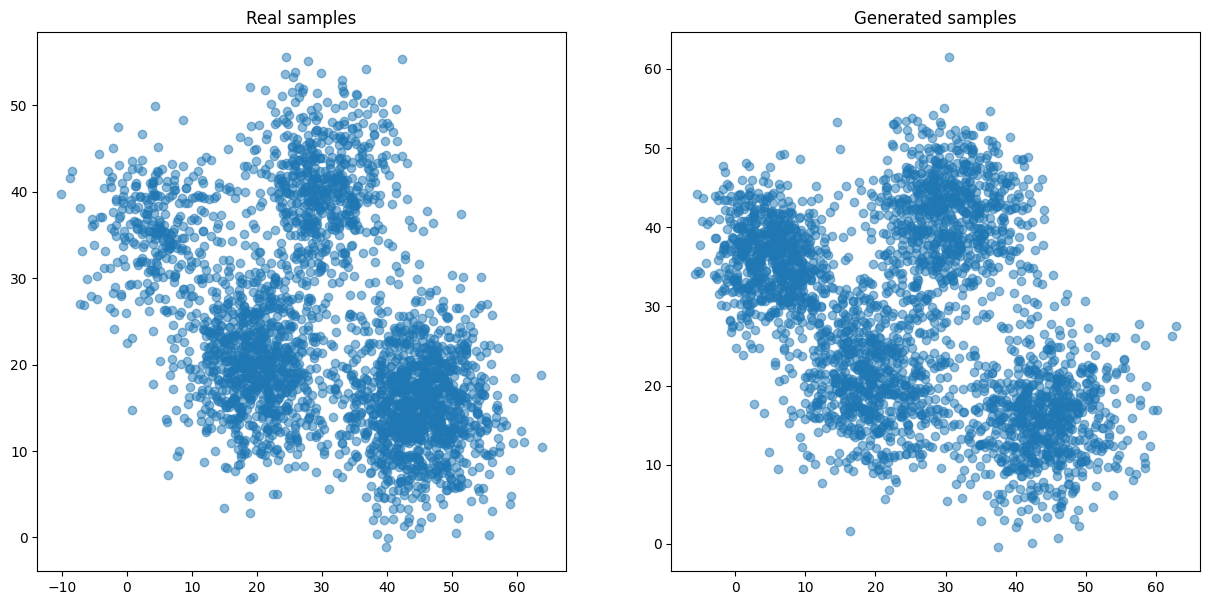

MSE Loss: 389.37042236328125


In [9]:
# Generate new samples
latent_space_samples = torch.randn(3000, latent_dim, device=device)
sample_z = torch.randint(0, 4, (3000,), device=device)
generated_samples = generator(latent_space_samples, sample_z.view(-1,1))
generated_samples = generated_samples.detach().cpu().numpy()  # Move data to CPU for plotting
train_data = train_data.cpu() 

# Plot the generated samples
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].scatter(train_data[:, 0], train_data[:, 1], alpha=0.5, label='Real samples')
axs[0].set_title('Real samples')
axs[1].scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label='Generated samples')
axs[1].set_title('Generated samples')
plt.show()

# Calculate MSE
mse = nn.MSELoss()
mse_loss = mse(train_data.float(), torch.tensor(generated_samples).float())
print(f"MSE Loss: {mse_loss}")
